In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from pathlib import Path
ROOT = Path('.')
gdrive = ROOT/'gdrive'/'My Drive'/'CS247_Project'

list(gdrive.iterdir())

[PosixPath('gdrive/My Drive/CS247_Project/src'),
 PosixPath('gdrive/My Drive/CS247_Project/.git'),
 PosixPath('gdrive/My Drive/CS247_Project/data'),
 PosixPath('gdrive/My Drive/CS247_Project/.DS_Store'),
 PosixPath('gdrive/My Drive/CS247_Project/.gitignore'),
 PosixPath('gdrive/My Drive/CS247_Project/GCN.ipynb'),
 PosixPath('gdrive/My Drive/CS247_Project/GCN with_timestamp.ipynb'),
 PosixPath('gdrive/My Drive/CS247_Project/data_explore (1).ipynb')]

In [0]:
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.optim as optim

import numpy as np
import pandas as pd
import argparse
import scipy.sparse as sp
import pickle
import easydict
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt

In [0]:
class GraphConvolution(Module):
    """
    Simple rGCN layer, similar to https://arxiv.org/abs/1703.06103
    :param num_relation: number of different relations in the data
    :param num_neighbors: a #relation x #node x 1 matrix that denotes number of neighbors of a node in a relation
    :param in_features: number of feature of the input
    :param out_features: number of feature of the ouput
    :param bias: if bias is added, default is True
    :type num_relation: int
    :type num_relation: int
    :type num_neighbors: array-like object, must be 3 dimension
    :type in_features: int
    :type out_features: int
    :type bias: bool
    """

    def __init__(self, num_relation, num_neighbors, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.adj_weight = Parameter(nn.init.kaiming_uniform_(torch.FloatTensor(num_relation + 1, in_features, out_features)))
        self.num_neighbors = num_neighbors
#         self.feature_weight = Parameter(nn.init.kaiming_uniform_(torch.FloatTensor(in_features, out_features)))
        self.attention = Parameter(nn.init.uniform_(torch.FloatTensor(num_relation + 1)))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.adj_weight.size(2))
        # self.weight.data.uniform_(-stdv, stdv)
        # self.adj_weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adjs):
        outputs = []
        num_node = adjs[0].shape[0]
        for i in range(len(self.adj_weight)):
            support = torch.mm(input, self.adj_weight[i])
            output = torch.spmm(adjs[i], support)
#             output = output / self.num_neighbors[i]
            output = output * F.softmax(self.attention, dim=0)[i]
            outputs.append(output)
        output = sum(outputs)
#         output = self.normalization(outputs)
        # feature_out = torch.mm(input, self.feature_weight)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def normalization(self, embedding: list) -> torch.Tensor:
        relations = []
        total_sum = 0.0
        for emb in embedding:
            relations.append(torch.sum(emb, dim=0))
        total_sum = sum(relations)
        relations = [relation / total_sum for relation in relations]

        # print(f"relation size {len(relations)}")

        relation_normalization = 0
        outputs = 0
        if embedding[0].device == 'cuda':
            relation_normalization = torch.stack(relations, dim=0).cuda()
            outputs = torch.stack(embedding, dim=0).cuda()
        else:
            relation_normalization = torch.stack(relations, dim=0)
            outputs = torch.stack(embedding, dim=0)
        assert type(relation_normalization) == torch.Tensor
        assert type(outputs) == torch.Tensor

        attention = []
        for i in range(embedding[0].size(1)):
            attention.append(self.attention)
        attention = torch.stack(attention, dim=1)
        attention = F.softmax(attention * relation_normalization, dim=0).reshape(len(embedding), 1, embedding[0].size(1))
        outputs = attention * outputs
        return torch.sum(outputs, dim=0)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [0]:
class rGCN(nn.Module):
    def __init__(self, num_relation, num_neighbors, nfeat, nhid, nclass, dropout):
        super(rGCN, self).__init__()

        self.gc1 = GraphConvolution(num_relation, num_neighbors, nfeat, nhid)
        self.gc2 = GraphConvolution(num_relation, num_neighbors, nhid, nclass)
        self.dropout = dropout

        
    '''
    featureless forward function. First x input is a (n x n) all one matrix.
    '''
    def forward(self, x, adjs):
        x = F.relu(self.gc1(x, adjs))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adjs)
        return F.log_softmax(x, dim=1)

In [0]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def plot_confusion_matrix(y_true, output, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, filename = None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    y_pred = output.max(1)[1].type_as(y_true)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes_val = list(classes.keys())
    classes_val = unique_labels(classes_val)[unique_labels(y_true, y_pred)]
    classes_name = [classes[i] for i in classes_val]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes_name, yticklabels=classes_name,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=6.5)
    fig.tight_layout()
    if filename:
        np.save(filename + '.npy', cm)
        fig.savefig(filename + '.png')
    return ax

def top_k_accuracy(output, labels, k):
  pred = torch.topk(output, k, dim=1)[1].type_as(labels)
  correct = pred.eq(labels.view(-1, 1).expand_as(pred)).double()
  correct = correct.sum()
  return correct / len(labels)

In [0]:
def train(data, model, optimizer, epoch):
#     features, adjs, idx_train, idx_val, labels = data
    features, adjs, idx_train, labels, label_mapping = data
    for i in range(epoch):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        output = model(features, adjs)
        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        optimizer.step()
  
        print('Epoch: {:04d}'.format(i+1),
              'loss_train: {:.4f}'.format(loss_train.item()),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'time: {:.4f}s'.format(time.time() - t))   
#         if not args.fastmode:
#         if True:
#             # Evaluate validation set performance separately,
            # deactivates dropout during validation run.
#             model.eval()
#             output = model(features, adjs)

#         loss_val = F.nll_loss(output[idx_val], labels[idx_val])
#         acc_val = accuracy(output[idx_val], labels[idx_val])
#         print('Epoch: {:04d}'.format(i+1),
#               'loss_train: {:.4f}'.format(loss_train.item()),
#               'acc_train: {:.4f}'.format(acc_train.item()),
#               'loss_val: {:.4f}'.format(loss_val.item()),
#               'acc_val: {:.4f}'.format(acc_val.item()),
#               'time: {:.4f}s'.format(time.time() - t))

In [0]:
def test(data, model):
    features, adj, idx_test, labels, label_mapping = data
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    acc_k_test = top_k_accuracy(output[idx_test], labels[idx_test], 3)
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()),
          "accuracy@3= {:.4f}".format(acc_k_test.item()))
    
    classes = label_mapping
    plot_confusion_matrix(labels[idx_test], output[idx_test], 
                          classes, normalize=True)

In [0]:
# def multi_relation_load(path="../data/", label="labels.csv", 
#                         files=["adj_phone.npz", "adj_app_installed.npz", "adj_app_active.npz"],
#                         label_mapping="label_mapping",
#                         train='train_idx', test='test_idx'):
def multi_relation_load(path="../data/", label="full_size_labels.csv", 
                        files=["full_size_adj_phone.npz", "full_size_adj_app_installed.npz", "full_size_adj_app_active.npz"],
                        label_mapping="label_mapping",
                        train='full_size_train_idx', test='full_size_test_idx'):
    print("Loading data from path {0}".format(path))
    DATA = Path(path)
    ADJS = [DATA/i for i in files]
    LABEL = DATA/label
    adjs = []
    label_df = pd.read_csv(LABEL)
    for adj in ADJS:
#         adjs.append(sp.load_npz(adj))
        adj_tilde = calculate_laplacian(sp.load_npz(adj))
        adjs.append(adj_tilde)
    
    with open(DATA/train, 'rb') as f:
        idx_train = pickle.load(f)
    with open(DATA/test, 'rb') as f:
        idx_test = pickle.load(f)
    f.close()
    
    with open(DATA/label_mapping, 'rb') as f:
        label_mapping = pickle.load(f)
    
    labels = label_df['group'].values
    
    total_node = adjs[0].shape[0]
    edge_indexs = np.array(range(total_node))
#     user_node = len(labels)
#     user_edge_indexs = np.array(range(user_node))
#     self_loop = sp.csr_matrix((np.ones(user_node), (user_edge_indexs, user_edge_indexs)), 
#                               shape=(total_node, total_node), dtype=np.float32)
    self_loop = sp.csr_matrix((np.ones(total_node), (edge_indexs, edge_indexs)), 
                              shape=(total_node, total_node), dtype=np.float32)
    adjs.append(self_loop)

    num_neighbors = [adjs[i].sum(1).reshape(total_node, 1) for i in range(len(adjs))]    
    # num_neighbors = [np.diff(adjs[i].indptr).reshape(n_entities, 1) for i in range(len(adjs))]
    for neighbor in num_neighbors:
        neighbor += 1 # smoothing
    num_neighbors = [torch.Tensor(neighbors) for neighbors in num_neighbors]

    print("\tprocessing features")
    
    # edge_indexs = np.array(range(n_entities))
    features = sp.csr_matrix((np.ones(total_node), (edge_indexs, edge_indexs)), shape=(total_node, total_node), dtype=np.float32) # dummy feature
    
    print("\ttransfering into tensors")

    features = sparse_mx_to_torch_sparse_tensor(features)
    labels = torch.LongTensor(labels)
    adjs = [sparse_mx_to_torch_sparse_tensor(adj) for adj in adjs]

    idx_train = torch.LongTensor(idx_train)
    idx_test = torch.LongTensor(idx_test)

    num_relation = len(files)
    return adjs, features, labels, label_mapping, idx_train, idx_test, num_neighbors, num_relation

In [0]:
def calculate_laplacian(adj):
  total_nodes = adj.shape[0]
  adj = adj + sp.identity(total_nodes)
  degree = adj.sum(axis=1)
  degree_sqrt_inv = np.sqrt(1.0 / degree).reshape(1, -1)
  D_sqrt_inv = sp.diags(degree_sqrt_inv, [0], shape=(total_nodes, total_nodes))
  adj_tilde = np.dot(np.dot(D_sqrt_inv, adj), D_sqrt_inv)
  return adj_tilde

In [0]:
def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--epochs', type=int, default=200,
#                         help='Number of epochs to train.')
#     parser.add_argument('--lr', type=float, default=0.01,
#                         help='Initial learning rate.')
#     parser.add_argument('--weight_decay', type=float, default=5e-4,
#                         help='Weight decay (L2 loss on parameters).')
#     parser.add_argument('--hidden', type=int, default=16,
#                         help='Number of hidden units.')
#     parser.add_argument('--dropout', type=float, default=0.5,
#                         help='Dropout rate (1 - keep probability).')
#     parser.add_argument('--data', type=str, default='../../data/twitter_1hop',
#                         help='path of the data folder.')
#     parser.add_argument('--relations', type=str, default=['friend_list.csv'], action='append',
#                         help='edge list files for different relations')

#     args = parser.parse_args()

    args = easydict.EasyDict({
        "epochs": 200,
        "lr": 0.01,
        "weight_decay": 5e-4,
        "hidden": 16,
        "dropout": 0.5,
        "data": 'gdrive/My Drive/CS247_Project/data'
    })

    CUDA = torch.cuda.is_available()
    np.random.seed(42)
    torch.manual_seed(42)
    if CUDA:
        torch.cuda.manual_seed(42)

    DATA = Path(args.data)
#     adjs, features, labels, idx_train, idx_val, idx_test, num_neighbors = multi_relation_load(DATA, files=args.relations)
    adjs, features, labels, label_mapping, idx_train, idx_test, num_neighbors, num_relation = multi_relation_load(DATA)
    if CUDA:
        features = features.cuda(0)
        adjs = [i.cuda(0) for i in adjs]
        labels = labels.cuda(0)
        idx_train = idx_train.cuda(0)
#         idx_val = idx_val.cuda(0)
        idx_test = idx_test.cuda(0)
        num_neighbors = [neighbors.cuda(0) for neighbors in num_neighbors]

    rGCN_model = rGCN(num_relation,
                num_neighbors,
                features.shape[1],
                args.hidden,
                labels.max().item() + 1,
                args.dropout)
    optimizer = optim.Adam(rGCN_model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)


    if CUDA:
        # rGCN_model = nn.DataParallel(rGCN_model)
        rGCN_model.cuda(0)

    # t_total = time.time()
    print("start training")
#     train([features, adjs, idx_train, idx_val, labels], rGCN_model, optimizer, args.epochs)
    train([features, adjs, idx_train, labels, label_mapping, ], rGCN_model, optimizer, args.epochs)
    # print("Optimization Finished!")
    # print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    test([features, adjs, idx_test, labels, label_mapping], rGCN_model)

Loading data from path gdrive/My Drive/CS247_Project/data
	processing features
	transfering into tensors
start training
Epoch: 0001 loss_train: 2.5294 acc_train: 0.0490 time: 2.3160s
Epoch: 0002 loss_train: 2.5041 acc_train: 0.0749 time: 2.3031s
Epoch: 0003 loss_train: 2.4848 acc_train: 0.1100 time: 2.1863s
Epoch: 0004 loss_train: 2.4715 acc_train: 0.1200 time: 2.1222s
Epoch: 0005 loss_train: 2.4628 acc_train: 0.1253 time: 2.0922s
Epoch: 0006 loss_train: 2.4561 acc_train: 0.1256 time: 2.1191s
Epoch: 0007 loss_train: 2.4506 acc_train: 0.1262 time: 2.1631s
Epoch: 0008 loss_train: 2.4464 acc_train: 0.1263 time: 2.1568s
Epoch: 0009 loss_train: 2.4447 acc_train: 0.1273 time: 2.1650s
Epoch: 0010 loss_train: 2.4423 acc_train: 0.1263 time: 2.1941s
Epoch: 0011 loss_train: 2.4421 acc_train: 0.1263 time: 2.1706s
Epoch: 0012 loss_train: 2.4394 acc_train: 0.1256 time: 2.1615s
Epoch: 0013 loss_train: 2.4372 acc_train: 0.1248 time: 2.1463s
Epoch: 0014 loss_train: 2.4351 acc_train: 0.1261 time: 2.1984

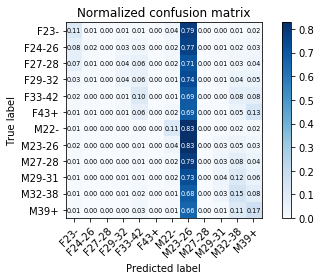

In [0]:
main()